# ATTENTION
什么是注意力:
- 我们观察事物时，之所以能够快速判断一种事物(当然允许判断是错误的), 是因为我们大脑能够很快把注意力放在事物最具有辨识度的部分从而作出判断，而并非是从头到尾的观察一遍事物后，才能有判断结果. 正是基于这样的理论，就产生了注意力机制.

什么是注意力计算规则:
- 它需要三个指定的输入Q(query), K(key), V(value), 然后通过计算公式得到注意力的结果, 这个结果代表query在key和value作用下的注意力表示. 当输入的Q=K=V时, 称作自注意力计算规则.

常见的注意力计算规则:
<img src='attention.png'>

什么是注意力机制:
- 注意力机制是注意力计算规则能够应用的深度学习网络的载体, 同时包括一些必要的全连接层以及相关张量处理, 使其与应用网络融为一体. 使用自注意力计算规则的注意力机制称为自注意力机制.

注意力机制的作用:

当前的注意力机制大多数应用于seq2seq架构, 即编码器和解码器模型.
- 在解码器端的注意力机制: 能够根据模型目标有效的聚焦编码器的输出结果, 当其作为解码器的输入时提升效果. 改善以往编码器输出是单一定长张量, 无法存储过多信息的情况.
- 在编码器端的注意力机制: 主要解决表征问题, 相当于特征提取过程, 得到输入的注意力表示. 一般使用自注意力(self-attention).

参考：
- https://zhuanlan.zhihu.com/p/43493999
- https://blog.csdn.net/malefactor/article/details/78767781

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attn(nn.Module):
    def __init__(self, query_size, key_size, value_size1, value_size2, output_size):
        """初始化函数中的参数有5个, query_size代表query的最后一维大小
           key_size代表key的最后一维大小, value_size1代表value的倒数第二维大小,
           value = (1, value_size1, value_size2)
           value_size2代表value的倒数第一维大小, output_size输出的最后一维大小"""
        super(Attn, self).__init__()
        # 将以下参数传入类中
        self.query_size = query_size
        self.key_size = key_size
        self.value_size1 = value_size1
        self.value_size2 = value_size2
        self.output_size = output_size

        # 初始化注意力机制实现第一步中需要的线性层.
        self.attn = nn.Linear(self.query_size + self.key_size, value_size1)

        # 初始化注意力机制实现第三步中需要的线性层.
        self.attn_combine = nn.Linear(self.query_size + value_size2, output_size)


    def forward(self, Q, K, V):
        """forward函数的输入参数有三个, 分别是Q, K, V, 根据模型训练常识, 输入给Attion机制的
           张量一般情况都是三维张量, 因此这里也假设Q, K, V都是三维张量"""

        # 第一步, 按照计算规则进行计算,
        # 我们采用常见的第一种计算规则
        # 将Q，K进行纵轴拼接, 做一次线性变化, 最后使用softmax处理获得结果(注意力向量)
        attn_weights = F.softmax(
            self.attn(torch.cat((Q[0], K[0]), 1)), dim=1)

        # 然后进行第一步的后半部分, 将得到的权重矩阵与V做矩阵乘法计算,
        # 当二者都是三维张量且第一维代表为batch条数时, 则做bmm运算
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), V)

        # 之后进行第二步, 通过取[0]是用来降维, 根据第一步采用的计算方法,
        # 需要将Q与第一步的计算结果再进行拼接
        output = torch.cat((Q[0], attn_applied[0]), 1)

        # 最后是第三步, 使用线性层作用在第三步的结果上做一个线性变换并扩展维度，得到输出
        # 因为要保证输出也是三维张量, 因此使用unsqueeze(0)扩展维度
        output = self.attn_combine(output).unsqueeze(0)
        return output, attn_weights, attn_applied


query_size = 32
key_size = 32
value_size1 = 32
value_size2 = 64
output_size = 64
attn = Attn(query_size, key_size, value_size1, value_size2, output_size)
Q = torch.randn(1,1,32) 
K = torch.randn(1,1,32)
V = torch.randn(1,32,64)
# Q = torch.randn(1,1,64)
# K = torch.randn(1,1,64) #错误如何改进
# V = torch.randn(1,32,64)
out = attn(Q, K ,V)
print(out[0].shape)
print(out[1].shape)
print(out[2].shape)
print(out[0]) #这个结果代表query在key和value作用下的注意力表示
# print(out[1]) #相似度
print(out[2]) 

torch.Size([1, 1, 64])
torch.Size([1, 32])
torch.Size([1, 1, 64])
tensor([[[-0.4893, -0.0382,  0.0750,  0.7484,  0.5957,  0.4762, -0.1784,
          -0.0109, -0.2045,  0.1959, -0.5979, -0.0367,  0.1800, -0.1001,
          -0.3183,  0.0361,  0.1113, -0.4263,  0.1688,  0.0389,  0.0921,
          -0.0892, -0.2930,  0.3485,  0.4557, -0.1532,  0.0632, -0.3931,
          -0.0258, -0.5209,  0.4012, -0.0616, -0.5532,  0.5394,  0.3082,
           0.0811,  0.5599,  0.0127, -0.3955,  0.1107, -0.3800,  0.2598,
           0.0978,  0.5679, -0.3533, -0.3098, -0.0513, -0.2024,  0.3421,
          -0.9749, -0.1686, -0.2651, -0.0335,  0.1254, -0.1123, -0.2561,
           0.0803, -0.5917,  0.1698,  0.2969, -0.4227, -0.0950, -0.0270,
           0.2790]]], grad_fn=<UnsqueezeBackward0>)
tensor([[[-0.4254, -0.1460, -0.1529,  0.3730,  0.3072, -0.1046, -0.0215,
          -0.1207, -0.1985,  0.0771,  0.0965,  0.0494,  0.0455,  0.3402,
          -0.4649, -0.2979, -0.1114,  0.1001, -0.1541, -0.2596, -0.0677,
      

举个例子。比如在预测“我妈今天做的这顿饭真好吃”的情感时，如果只预测正向还是负向，那真正影响结果的只有“真好吃”这三个字，前面说的“我妈今天做的这顿饭”基本没什么用，如果是直接对token embedding进行平均去求句子表示会引入不少噪声。所以引入attention机制，让我们可以根据任务目标赋予输入token不同的权重，理想情况下前半句的权重都在0.0及，后三个字则是“0.3, 0.3, 0.3”，在计算句子表示时就变成了：

最终表示 = 0.01x我+0.01x妈+0.01x今+0.01x天+0.01x做+0.01x的+0.01x这+0.01x顿+0.02x饭+0.3x真+0.3x好+0.3x吃

机器翻译：
<!-- torch.Size([25])
torch.Size([1, 1, 25])
经过线性映射
torch.Size([10, 25]) -->
Q = torch.randn(1,1,32) 待翻译语言的一个词表示 batch_size,一个词, 编码器hidden_size

K = torch.randn(1,1,32) 编码器输出的整句表示

V = torch.randn(1,32,64) 编码器输出的所有词表示 batch_size, 句子序列长度（词数），hidden_size

In [ ]:
# 如果参数1形状是(b × n × m), 参数2形状是(b × m × p), 则输出为(b × n × p) 矩阵乘法
input = torch.randn(10, 3, 4)
mat2 = torch.randn(10, 4, 5)
res = torch.bmm(input, mat2)
res.size()

torch.Size([10, 3, 5])

## 使用seq2seq模型架构实现英译法任务
学习目标:
- 更深一步了解seq2seq模型架构和翻译数据集.
- 掌握使用基于GRU的seq2seq模型架构实现翻译的过程.
- 掌握Attention机制在解码器端的实现过程.

<img src='seq2seq.jpg'>

从图中可知, seq2seq模型架构, 包括两部分分别是encoder(编码器)和decoder(解码器), 编码器和解码器的内部实现都使用了GRU模型, 这里它要完成的是一个中文到英文的翻译: 欢迎 来 北京 --> welcome to BeiJing. 编码器首先处理中文输入"欢迎 来 北京", 通过GRU模型获得每个时间步的输出张量，最后将它们拼接成一个中间语义张量c, 接着解码器将使用这个中间语义张量c以及每一个时间步的隐层张量, 逐个生成对应的翻译语言.

In [4]:
import os
print(os.getcwd())
f = open('./data/data/eng-fra.txt','r')
data = f.readlines()
data[:10]

/home/yangcaihua/task/base_model


['Go.\tVa !\n',
 'Run!\tCours\u202f!\n',
 'Run!\tCourez\u202f!\n',
 'Wow!\tÇa alors\u202f!\n',
 'Fire!\tAu feu !\n',
 "Help!\tÀ l'aide\u202f!\n",
 'Jump.\tSaute.\n',
 'Stop!\tÇa suffit\u202f!\n',
 'Stop!\tStop\u202f!\n',
 'Stop!\tArrête-toi !\n']

基于GRU的seq2seq模型架构实现翻译的过程:

- 第一步: 导入必备的工具包.
- 第二步: 对持久化文件中数据进行处理, 以满足模型训练要求.
- 第三步: 构建基于GRU的编码器和解码器.
- 第四步: 构建模型训练函数, 并进行训练.
- 第五步: 构建模型评估函数, 并进行测试以及Attention效果分析.

In [5]:
# 从io工具包导入open方法
from io import open
# 用于字符规范化
import unicodedata
# 用于正则表达式
import re
# 用于随机生成数据
import random
# 用于构建网络结构和函数的torch工具包
import torch
import torch.nn as nn
import torch.nn.functional as F
# torch中预定义的优化方法工具包
from torch import optim
# 设备选择, 我们可以选择在cuda或者cpu上运行你的代码
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# 起始标志
SOS_token = 0
# 结束标志
EOS_token = 1

class Lang:
    def __init__(self, name):
        """初始化函数中参数name代表传入某种语言的名字"""
        # 将name传入类中
        self.name = name
        # 初始化词汇对应自然数值的字典
        self.word2index = {}
        # 初始化自然数值对应词汇的字典, 其中0，1对应的SOS和EOS已经在里面了
        self.index2word = {0: "SOS", 1: "EOS"}
        # 初始化词汇对应的自然数索引，这里从2开始，因为0，1已经被开始和结束标志占用了
        self.n_words = 2  

    def addSentence(self, sentence):
        """添加句子函数, 即将句子转化为对应的数值序列, 输入参数sentence是一条句子"""
        # 根据一般国家的语言特性(我们这里研究的语言都是以空格分个单词)
        # 对句子进行分割，得到对应的词汇列表
        for word in sentence.split(' '):
            # 然后调用addWord进行处理
            self.addWord(word)


    def addWord(self, word):
        """添加词汇函数, 即将词汇转化为对应的数值, 输入参数word是一个单词"""
        # 首先判断word是否已经在self.word2index字典的key中
        if word not in self.word2index:
            # 如果不在, 则将这个词加入其中, 并为它对应一个数值，即self.n_words
            self.word2index[word] = self.n_words
            # 同时也将它的反转形式加入到self.index2word中
            self.index2word[self.n_words] = word
            # self.n_words一旦被占用之后，逐次加1, 变成新的self.n_words
            self.n_words += 1

In [7]:
name = "eng"
sentence = "hello I am Jay"
engl = Lang(name)
engl.addSentence(sentence)
print("word2index:", engl.word2index)
print("index2word:", engl.index2word)
print("n_words:", engl.n_words)

word2index: {'hello': 2, 'I': 3, 'am': 4, 'Jay': 5}
index2word: {0: 'SOS', 1: 'EOS', 2: 'hello', 3: 'I', 4: 'am', 5: 'Jay'}
n_words: 6


In [8]:
# 将unicode转为Ascii, 我们可以认为是去掉一些语言中的重音标记：Ślusàrski
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    """字符串规范化函数, 参数s代表传入的字符串"""
    # 使字符变为小写并去除两侧空白符, z再使用unicodeToAscii去掉重音标记
    s = unicodeToAscii(s.lower().strip())
    # 在.!?前加一个空格
    s = re.sub(r"([.!?])", r" \1", s)
    # 使用正则表达式将字符串中不是大小写字母和正常标点的都替换成空格
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [9]:
s = "Are you kidding me?"
nsr = normalizeString(s)
print(nsr)

are you kidding me ?


In [10]:
data_path = './data/data/eng-fra.txt'

def readLangs(lang1, lang2):
    """读取语言函数, 参数lang1是源语言的名字, 参数lang2是目标语言的名字
       返回对应的class Lang对象, 以及语言对列表"""
    # 从文件中读取语言对并以/n划分存到列表lines中
    lines = open(data_path, encoding='utf-8').\
        read().strip().split('\n')
    # 对lines列表中的句子进行标准化处理，并以\t进行再次划分, 形成子列表, 也就是语言对
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines] 
    # 然后分别将语言名字传入Lang类中, 获得对应的语言对象, 返回结果
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

In [ ]:
lang1 = "eng"
lang2 = "fra"
input_lang, output_lang, pairs = readLangs(lang1, lang2)
print("input_lang:", input_lang)
print("output_lang:", output_lang)
print("pairs中的前五个:", pairs[:5])

input_lang: <__main__.Lang object at 0x7f83d4d81130>
output_lang: <__main__.Lang object at 0x7f83656c8130>
pairs中的前五个: [['go .', 'va !'], ['run !', 'cours !'], ['run !', 'courez !'], ['wow !', 'ca alors !'], ['fire !', 'au feu !']]


In [11]:
# 设置组成句子中单词或标点的最多个数
MAX_LENGTH = 10

# 选择带有指定前缀的语言特征数据作为训练数据
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    """语言对过滤函数, 参数p代表输入的语言对, 如['she is afraid.', 'elle malade.']"""
    # p[0]代表英语句子，对它进行划分，它的长度应小于最大长度MAX_LENGTH并且要以指定的前缀开头
    # p[1]代表法文句子, 对它进行划分，它的长度应小于最大长度MAX_LENGTH
    return len(p[0].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes) and \
        len(p[1].split(' ')) < MAX_LENGTH 


def filterPairs(pairs):
    """对多个语言对列表进行过滤, 参数pairs代表语言对组成的列表, 简称语言对列表"""
    # 函数中直接遍历列表中的每个语言对并调用filterPair即可
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
# 输入参数pairs使用readLangs函数的输出结果pairs
fpairs = filterPairs(pairs)
print("过滤后的pairs前五个:", fpairs[:5])

过滤后的pairs前五个: [['i m .', 'j ai ans .'], ['i m ok .', 'je vais bien .'], ['i m ok .', 'ca va .'], ['i m fat .', 'je suis gras .'], ['i m fat .', 'je suis gros .']]


In [12]:
def prepareData(lang1, lang2):
    """数据准备函数, 完成将所有字符串数据向数值型数据的映射以及过滤语言对
       参数lang1, lang2分别代表源语言和目标语言的名字"""
    # 首先通过readLangs函数获得input_lang, output_lang对象，以及字符串类型的语言对列表
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    # 对字符串类型的语言对列表进行过滤操作
    pairs = filterPairs(pairs)
    # 对过滤后的语言对列表进行遍历
    for pair in pairs:
        # 并使用input_lang和output_lang的addSentence方法对其进行数值映射
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    # 返回数值映射后的对象, 和过滤后语言对
    return input_lang, output_lang, pairs

In [16]:
input_lang, output_lang, pairs = prepareData('eng', 'fra')
print("input_n_words:", input_lang.n_words)
print("output_n_words:", output_lang.n_words)
print(random.choice(pairs))

input_n_words: 2803
output_n_words: 4345
['you re taller than i am .', 'tu es plus grande que moi .']


In [13]:
def tensorFromSentence(lang, sentence):
    """将文本句子转换为张量, 参数lang代表传入的Lang的实例化对象, sentence是预转换的句子"""
    # 对句子进行分割并遍历每一个词汇, 然后使用lang的word2index方法找到它对应的索引
    # 这样就得到了该句子对应的数值列表
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    # 然后加入句子结束标志
    indexes.append(EOS_token)
    # 将其使用torch.tensor封装成张量, 并改变它的形状为nx1, 以方便后续计算
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    """将语言对转换为张量对, 参数pair为一个语言对"""
    # 调用tensorFromSentence分别将源语言和目标语言分别处理，获得对应的张量表示
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    # 最后返回它们组成的元组
    return (input_tensor, target_tensor)

In [17]:
# 取pairs的第一条
pair = pairs[0]
print(pair)
pair_tensor = tensorsFromPair(pair)
print(pair_tensor)

['i m .', 'j ai ans .']
(tensor([[2],
        [3],
        [4],
        [1]], device='cuda:0'), tensor([[2],
        [3],
        [4],
        [5],
        [1]], device='cuda:0'))


In [41]:
# 构建基于GRU的编码器和解码器
# 熟悉GRU的使用
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        """它的初始化参数有两个, input_size代表解码器的输入尺寸即源语言的
            词表大小，hidden_size代表GRU的隐层节点数, 也代表词嵌入维度, 同时又是GRU的输入尺寸"""
        super(EncoderRNN, self).__init__()
        # 将参数hidden_size传入类中
        self.hidden_size = hidden_size
        # 实例化nn中预定义的Embedding层, 它的参数分别是input_size, hidden_size
        # 这里的词嵌入维度即hidden_size
        # nn.Embedding的演示在该代码下方
        self.embedding = nn.Embedding(input_size, hidden_size)
        # 然后实例化nn中预定义的GRU层, 它的参数是hidden_size
        # nn.GRU的演示在该代码下方
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        """编码器前向逻辑函数中参数有两个, input代表源语言的Embedding层输入张量
           hidden代表编码器层gru的初始隐层张量"""
        # 将输入张量进行embedding操作, 并使其形状变为(1,1,-1),-1代表自动计算维度
        # 理论上，我们的编码器每次只以一个词作为输入, 因此词汇映射后的尺寸应该是[1, embedding]
        # 而这里转换成三维的原因是因为torch中预定义gru必须使用三维张量作为输入, 因此我们拓展了一个维度
        output = self.embedding(input).view(1, 1, -1)
        # 然后将embedding层的输出和传入的初始hidden作为gru的输入传入其中,
        # 获得最终gru的输出output和对应的隐层张量hidden， 并返回结果
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        """初始化隐层张量函数"""
        # 将隐层张量初始化成为1x1xself.hidden_size大小的0张量
        return torch.zeros(1, 1, self.hidden_size, device=device)

hidden_size = 25
input_size = 20
# pair_tensor[0]代表源语言即英文的句子，pair_tensor[0][0]代表句子中的第一个词
input = pair_tensor[0][0]
# 初始化第一个隐层张量，1x1xhidden_size的0张量
hidden = torch.zeros(1, 1, hidden_size,device=device)

encoder = EncoderRNN(input_size, hidden_size).to(device)
print(input.shape)
print(input)
print(hidden.shape)
encoder_output, hidden = encoder(input, hidden)
print(encoder_output.shape)
print(encoder_output[0,0])
print(hidden.shape)
print(encoder_output)

torch.Size([1])
tensor([2], device='cuda:0')
torch.Size([1, 1, 25])
torch.Size([1, 1, 25])
tensor([-0.0254,  0.0228, -0.1346,  0.3894,  0.1858, -0.1637, -0.0146,  0.0163,
        -0.4015, -0.0347,  0.1751, -0.0388, -0.3266,  0.1680, -0.1460,  0.1826,
         0.2827,  0.1239, -0.2258, -0.1448,  0.2776,  0.1969, -0.1018, -0.1085,
         0.4144], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([1, 1, 25])
tensor([[[-0.0254,  0.0228, -0.1346,  0.3894,  0.1858, -0.1637, -0.0146,
           0.0163, -0.4015, -0.0347,  0.1751, -0.0388, -0.3266,  0.1680,
          -0.1460,  0.1826,  0.2827,  0.1239, -0.2258, -0.1448,  0.2776,
           0.1969, -0.1018, -0.1085,  0.4144]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)


In [19]:
# 构建基于GRU和Attention的解码器
# 用于探索attention的使用
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """初始化函数中的参数有4个, hidden_size代表解码器中GRU的输入尺寸，也是它的隐层节点数
           output_size代表整个解码器的输出尺寸, 也是我们希望得到的指定尺寸即目标语言的词表大小
           dropout_p代表我们使用dropout层时的置零比率，默认0.1, max_length代表句子的最大长度"""
        super(AttnDecoderRNN, self).__init__()
        # 将以下参数传入类中
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # 实例化一个Embedding层, 输入参数是self.output_size和self.hidden_size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # 根据attention的QKV理论，attention的输入参数为三个Q，K，V，
        # 第一步，使用Q与K进行attention权值计算得到权重矩阵, 再与V做矩阵乘法, 得到V的注意力表示结果.
        # 这里常见的计算方式有三种:
        # 1，将Q，K进行纵轴拼接, 做一次线性变化, 再使用softmax处理获得结果最后与V做张量乘法
        # 2，将Q，K进行纵轴拼接, 做一次线性变化后再使用tanh函数激活, 然后再进行内部求和, 最后使用softmax处理获得结果再与V做张量乘法
        # 3，将Q与K的转置做点积运算, 然后除以一个缩放系数, 再使用softmax处理获得结果最后与V做张量乘法

        # 说明：当注意力权重矩阵和V都是三维张量且第一维代表为batch条数时, 则做bmm运算.

        # 第二步, 根据第一步采用的计算方法, 如果是拼接方法，则需要将Q与第二步的计算结果再进行拼接, 
        # 如果是转置点积, 一般是自注意力, Q与V相同, 则不需要进行与Q的拼接.因此第二步的计算方式与第一步采用的全值计算方法有关.
        # 第三步，最后为了使整个attention结构按照指定尺寸输出, 使用线性层作用在第二步的结果上做一个线性变换. 得到最终对Q的注意力表示.

        # 我们这里使用的是第一步中的第一种计算方式, 因此需要一个线性变换的矩阵, 实例化nn.Linear
        # 因为它的输入是Q，K的拼接, 所以输入的第一个参数是self.hidden_size * 2，第二个参数是self.max_length
        # 这里的Q是解码器的Embedding层的输出, K是解码器GRU的隐层输出，因为首次隐层还没有任何输出，会使用编码器的隐层输出
        # 而这里的V是编码器层的输出
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        # 接着我们实例化另外一个线性层, 它是attention理论中的第四步的线性层，用于规范输出尺寸
        # 这里它的输入来自第三步的结果, 因为第三步的结果是将Q与第二步的结果进行拼接, 因此输入维度是self.hidden_size * 2
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        # 接着实例化一个nn.Dropout层，并传入self.dropout_p
        self.dropout = nn.Dropout(self.dropout_p)
        # 之后实例化nn.GRU, 它的输入和隐层尺寸都是self.hidden_size
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        # 最后实例化gru后面的线性层，也就是我们的解码器输出层.
        self.out = nn.Linear(self.hidden_size, self.output_size)

    # 将decoder_input(法语), decoder_hidden（encoder隐层输出）, encoder_outputs（每个位置输出）即attention中的QKV
    # QK 为啥代表相似度
    def forward(self, input, hidden, encoder_outputs):
        """forward函数的输入参数有三个, 分别是源数据输入张量, 初始的隐层张量, 以及解码器的输出张量"""

        # 根据结构计算图, 输入张量进行Embedding层并扩展维度
        embedded = self.embedding(input).view(1, 1, -1)
        # 使用dropout进行随机丢弃，防止过拟合
        embedded = self.dropout(embedded)

        # 进行attention的权重计算, 我们呢使用第一种计算方式：
        # 将Q，K进行纵轴拼接, 做一次线性变化, 最后使用softmax处理获得结果
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        # 然后进行第一步的后半部分, 将得到的权重矩阵与V做矩阵乘法计算, 当二者都是三维张量且第一维代表为batch条数时, 则做bmm运算
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # 之后进行第二步, 通过取[0]是用来降维, 根据第一步采用的计算方法, 需要将Q与第一步的计算结果再进行拼接
        output = torch.cat((embedded[0], attn_applied[0]), 1)

        # 最后是第三步, 使用线性层作用在第三步的结果上做一个线性变换并扩展维度，得到输出
        output = self.attn_combine(output).unsqueeze(0)

        # attention结构的结果使用relu激活
        output = F.relu(output)

        # 将激活后的结果作为gru的输入和hidden一起传入其中
        output, hidden = self.gru(output, hidden)

        # 最后将结果降维并使用softmax处理得到最终的结果
        output = F.log_softmax(self.out(output[0]), dim=1)
        # 返回解码器结果，最后的隐层张量以及注意力权重张量
        return output, hidden, attn_weights

    def initHidden(self):
        """初始化隐层张量函数"""
        # 将隐层张量初始化成为1x1xself.hidden_size大小的0张量
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [47]:
hidden_size = 25
output_size = 10
input = pair_tensor[1][0]

hidden = torch.zeros(1, 1, hidden_size,device=device)
# encoder_outputs需要是encoder中每一个时间步的输出堆叠而成
# 它的形状应该是10x25, 我们这里直接随机初始化一个张量
encoder_outputs  = torch.randn(10, 25, device=device)
decoder = AttnDecoderRNN(hidden_size, output_size).to(device)
print(input.shape)
print(hidden.shape)
print(encoder_outputs.shape)
output, hidden, attn_weights= decoder(input, hidden, encoder_outputs)
print(output.shape)
print(hidden.shape)
print(attn_weights.shape)

torch.Size([1])
torch.Size([1, 1, 25])
torch.Size([10, 25])
torch.Size([1, 10])
torch.Size([1, 1, 25])
torch.Size([1, 10])


什么是teacher_forcing?
- 它是一种用于序列生成任务的训练技巧, 在seq2seq架构中, 根据循环神经网络理论，解码器每次应该使用上一步的结果作为输入的一部分, 但是训练过程中，一旦上一步的结果是错误的，就会导致这种错误被累积，无法达到训练效果, 因此，我们需要一种机制改变上一步出错的情况，因为训练时我们是已知正确的输出应该是什么，因此可以强制将上一步结果设置成正确的输出, 这种方式就叫做teacher_forcing.

teacher_forcing的作用:
- 能够在训练的时候矫正模型的预测，避免在序列生成的过程中误差进一步放大.
- teacher_forcing能够极大的加快模型的收敛速度，令模型训练过程更快更平稳.

In [25]:
# 构建训练函数:
# 设置teacher_forcing比率为0.5
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """训练函数, 输入参数有8个, 分别代表input_tensor：源语言输入张量，target_tensor：目标语言输入张量，encoder, decoder：编码器和解码器实例化对象
       encoder_optimizer, decoder_optimizer：编码器和解码器优化方法，criterion：损失函数计算方法，max_length：句子的最大长度"""
    # loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    # 初始化隐层张量
    encoder_hidden = encoder.initHidden()

    # 编码器和解码器优化器梯度归0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # 根据源文本和目标文本张量获得对应的长度
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # 初始化编码器输出张量，形状是max_length x encoder.hidden_size的0张量
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # 初始设置损失为0
    loss = 0

    # 循环遍历输入张量索引
    for ei in range(input_length):
        # 根据索引从input_tensor取出对应的单词的张量表示，和初始化隐层张量一同传入encoder对象中
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        # 将每次获得的输出encoder_output(三维张量), 使用[0, 0]降两维变成向量依次存入到encoder_outputs
        # 这样encoder_outputs每一行存的都是对应的句子中每个单词通过编码器的输出结果
        encoder_outputs[ei] = encoder_output[0, 0]

    # 初始化解码器的第一个输入，即起始符
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # 初始化解码器的隐层张量即编码器的隐层输出
    decoder_hidden = encoder_hidden

    # 根据随机数与teacher_forcing_ratio对比判断是否使用teacher_forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # 如果使用teacher_forcing
    if use_teacher_forcing:
        # 循环遍历目标张量索引
        for di in range(target_length):
            # 将decoder_input, decoder_hidden, encoder_outputs即attention中的QKV, 
            # 传入解码器对象, 获得decoder_output, decoder_hidden, decoder_attention
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # 因为使用了teacher_forcing, 无论解码器输出的decoder_output是什么, 我们都只
            # 使用‘正确的答案’，即target_tensor[di]来计算损失
            loss += criterion(decoder_output, target_tensor[di])
            # 并强制将下一次的解码器输入设置为‘正确的答案’
            decoder_input = target_tensor[di]

    else:
        # 如果不使用teacher_forcing
        # 仍然遍历目标张量索引
        for di in range(target_length):
            # 将decoder_input, decoder_hidden, encoder_outputs传入解码器对象
            # 获得decoder_output, decoder_hidden, decoder_attention
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # 只不过这里我们将从decoder_output取出答案
            topv, topi = decoder_output.topk(1)
            # 损失计算仍然使用decoder_output和target_tensor[di]
            loss += criterion(decoder_output, target_tensor[di])
            # 最后如果输出值是终止符，则循环停止
            if topi.squeeze().item() == EOS_token:
                break
            # 否则，并对topi降维并分离赋值给decoder_input以便进行下次运算
            # 这里的detach的分离作用使得这个decoder_input与模型构建的张量图无关，相当于全新的外界输入
            decoder_input = topi.squeeze().detach()


    # 误差进行反向传播
    loss.backward()
    # 编码器和解码器进行优化即参数更新
    encoder_optimizer.step()
    decoder_optimizer.step()

    # 最后返回平均损失
    return loss.item() / target_length

In [26]:
# 构建时间计算函数:
# 导入时间和数学工具包
import time
import math

def timeSince(since):
    "获得每次打印的训练耗时, since是训练开始时间"
    # 获得当前时间
    now = time.time()
    # 获得时间差，就是训练耗时
    s = now - since
    # 将秒转化为分钟, 并取整
    m = math.floor(s / 60)
    # 计算剩下不够凑成1分钟的秒数
    s -= m * 60
    # 返回指定格式的耗时
    return '%dm %ds' % (m, s)

In [27]:
# 假定模型训练开始时间是10min之前
since = time.time() - 10*60
period = timeSince(since)
print(period)

10m 0s


In [28]:
# 导入plt以便绘制损失曲线
import matplotlib.pyplot as plt

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    """训练迭代函数, 输入参数有6个，分别是encoder, decoder: 编码器和解码器对象，
       n_iters: 总迭代步数, print_every:打印日志间隔, plot_every:绘制损失曲线间隔, learning_rate学习率"""
    # 获得训练开始时间戳
    start = time.time()
    # 每个损失间隔的平均损失保存列表，用于绘制损失曲线
    plot_losses = []

    # 每个打印日志间隔的总损失，初始为0
    print_loss_total = 0  
    # 每个绘制损失间隔的总损失，初始为0
    plot_loss_total = 0  

    # 使用预定义的SGD作为优化器，将参数和学习率传入其中
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # 选择损失函数
    criterion = nn.NLLLoss()

    # 根据设置迭代步进行循环
    for iter in range(1, n_iters + 1):
        # 每次从语言对列表中随机取出一条作为训练语句
        training_pair = tensorsFromPair(random.choice(pairs))
        # 分别从training_pair中取出输入张量和目标张量
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # 通过train函数获得模型运行的损失
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        # 将损失进行累和
        print_loss_total += loss
        plot_loss_total += loss

        # 当迭代步达到日志打印间隔时
        if iter % print_every == 0:
            # 通过总损失除以间隔得到平均损失
            print_loss_avg = print_loss_total / print_every
            # 将总损失归0
            print_loss_total = 0
            # 打印日志，日志内容分别是：训练耗时，当前迭代步，当前进度百分比，当前平均损失
            print('%s (%d %d%%) %.4f' % (timeSince(start),
                                         iter, iter / n_iters * 100, print_loss_avg))

        # 当迭代步达到损失绘制间隔时
        if iter % plot_every == 0:
            # 通过总损失除以间隔得到平均损失
            plot_loss_avg = plot_loss_total / plot_every
            # 将平均损失装进plot_losses列表
            plot_losses.append(plot_loss_avg)
            # 总损失归0
            plot_loss_total = 0

    # 绘制损失曲线
    plt.figure()  
    plt.plot(plot_losses)
    # 保存到指定路径
    plt.savefig("./s2s_loss.png")

In [31]:
# 设置隐层大小为256 ，也是词嵌入维度      
hidden_size = 256
# 通过input_lang.n_words获取输入词汇总数，与hidden_size一同传入EncoderRNN类中
# 得到编码器对象encoder1
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)

# 通过output_lang.n_words获取目标词汇总数，与hidden_size和dropout_p一同传入AttnDecoderRNN类中
# 得到解码器对象attn_decoder1
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# 设置迭代步数 
n_iters = 10000
# 设置日志打印间隔
print_every = 5000 

1m 2s (5000 50%) 3.4391
2m 6s (10000 100%) 2.7804


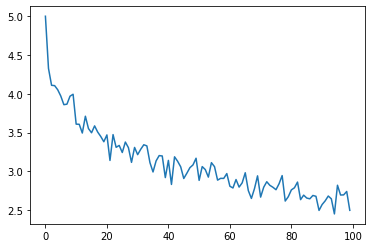

In [32]:
# 调用trainIters进行模型训练，将编码器对象encoder1，解码器对象attn_decoder1，迭代步数，日志打印间隔传入其中
trainIters(encoder1, attn_decoder1, n_iters, print_every=print_every)

In [33]:
# 构建模型评估函数, 并进行测试以及Attention效果分析.
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """评估函数，输入参数有4个，分别是encoder, decoder: 编码器和解码器对象，
       sentence:需要评估的句子，max_length:句子的最大长度"""

    # 评估阶段不进行梯度计算
    with torch.no_grad():
        # 对输入的句子进行张量表示
        input_tensor = tensorFromSentence(input_lang, sentence)
        # 获得输入的句子长度
        input_length = input_tensor.size()[0]
        # 初始化编码器隐层张量
        encoder_hidden = encoder.initHidden()

        # 初始化编码器输出张量，是max_lengthxencoder.hidden_size的0张量
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # 循环遍历输入张量索引
        for ei in range(input_length):
             # 根据索引从input_tensor取出对应的单词的张量表示，和初始化隐层张量一同传入encoder对象中
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            #将每次获得的输出encoder_output(三维张量), 使用[0, 0]降两维变成向量依次存入到encoder_outputs
            # 这样encoder_outputs每一行存的都是对应的句子中每个单词通过编码器的输出结果
            encoder_outputs[ei] += encoder_output[0, 0]

        # 初始化解码器的第一个输入，即起始符
        decoder_input = torch.tensor([[SOS_token]], device=device) 
        # 初始化解码器的隐层张量即编码器的隐层输出
        decoder_hidden = encoder_hidden

        # 初始化预测的词汇列表
        decoded_words = []
        # 初始化attention张量
        decoder_attentions = torch.zeros(max_length, max_length)
        # 开始循环解码
        for di in range(max_length):
            # 将decoder_input, decoder_hidden, encoder_outputs传入解码器对象
            # 获得decoder_output, decoder_hidden, decoder_attention
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # 取所有的attention结果存入初始化的attention张量中
            decoder_attentions[di] = decoder_attention.data
            # 从解码器输出中获得概率最高的值及其索引对象
            topv, topi = decoder_output.data.topk(1)
            # 从索引对象中取出它的值与结束标志值作对比
            if topi.item() == EOS_token:
                # 如果是结束标志值，则将结束标志装进decoded_words列表，代表翻译结束
                decoded_words.append('<EOS>')
                # 循环退出
                break

            else:
                # 否则，根据索引找到它在输出语言的index2word字典中对应的单词装进decoded_words
                decoded_words.append(output_lang.index2word[topi.item()])

            # 最后将本次预测的索引降维并分离赋值给decoder_input，以便下次进行预测
            decoder_input = topi.squeeze().detach()
        # 返回结果decoded_words， 以及完整注意力张量, 把没有用到的部分切掉
        return decoded_words, decoder_attentions[:di + 1]

In [34]:
# 随机选择指定数量的数据进行评估:
def evaluateRandomly(encoder, decoder, n=6):
    """随机测试函数, 输入参数encoder, decoder代表编码器和解码器对象，n代表测试数"""
    # 对测试数进行循环
    for i in range(n):
        # 从pairs随机选择语言对
        pair = random.choice(pairs)
        # > 代表输入
        print('>', pair[0])
        # = 代表正确的输出
        print('=', pair[1])
        # 调用evaluate进行预测
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        # 将结果连成句子
        output_sentence = ' '.join(output_words)
        # < 代表模型的输出
        print('<', output_sentence)
        print('')

In [35]:
# 调用evaluateRandomly进行模型测试，将编码器对象encoder1，码器对象attn_decoder1传入其中
evaluateRandomly(encoder1, attn_decoder1)

> i m getting tired of this .
= ca me fatigue .
< je suis assez d d . <EOS>

> he is tired of watching television .
= il est fatigue de regarder la television .
< il a a d de . . <EOS>

> he s lived here his entire life .
= il a vecu ici sa vie entiere .
< il est de de son . <EOS>

> i m chicken .
= j ai les foies .
< je suis desole . <EOS>

> they re in danger .
= elles sont en danger .
< ils sont en . . <EOS>

> you re the one who trained me .
= vous etes celui qui m a formee .
< c est vous qui m a . . <EOS>



['nous', 'sommes', 'tous', 'a', '.', '<EOS>']


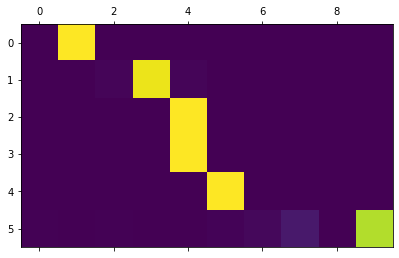

In [36]:
sentence = "we re both teachers ."
# 调用评估函数
output_words, attentions = evaluate(
encoder1, attn_decoder1, sentence)
print(output_words)
# 将attention张量转化成numpy, 使用matshow绘制
plt.matshow(attentions.numpy())
# 保存图像
plt.savefig("./s2s_attn.png")

Attention图像的纵坐标代表输入的源语言各个词汇对应的索引, 0-6分别对应["we", "re", "both", "teachers", ".", ""], 纵坐标代表生成的目标语言各个词汇对应的索引, 0-7代表['nous', 'sommes', 'toutes', 'deux', 'enseignantes', '.', ''], 图中浅色小方块(颜色越浅说明影响越大)代表词汇之间的影响关系, 比如源语言的第1个词汇对生成目标语言的第1个词汇影响最大, 源语言的第4，5个词对生成目标语言的第5个词会影响最大, 通过这样的可视化图像, 我们可以知道Attention的效果好坏, 与我们人为去判定到底还有多大的差距. 进而衡量我们训练模型的可用性.
